In [1]:
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from glob import glob
from playsound import playsound
from IPython.display import Audio
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy import signal
import wave
import os
import json

In [2]:
def calc_cepstrum(data):
    """
    Calculates the complex cepstrum of a real sequence.
    """
    spectrum = np.fft.fft(data)
    log_spectrum = np.log(np.abs(spectrum))
    cepstrum = np.fft.ifft(log_spectrum).real
    return cepstrum


def find_fundamental_freq(samples, sr, freq_range):
    cepstrum = calc_cepstrum(samples)
    """
    Finding fundamental frequency of tested sound
    """

    min_freq, max_freq = freq_range
    start = int(sr / max_freq)
    end = int(sr / min_freq)
    narrowed_cepstrum = cepstrum[start:end]
    peak_ix = narrowed_cepstrum.argmax()
    freq0 = sr / (start + peak_ix)

    # print(f'shape of cepstrum {cepstrum.shape}')
    # print(f'min freq: {min_freq}')
    # print(f'max freq: {max_freq}')
    # print(f'start: {start}')
    # print(f'end: {end}')
    # # print(f'narrowed spectrum: {narrowed_cepstrum}')
    # print(f'peak_ix: {peak_ix}')
    # print(f'freq0: {freq0}')

    if freq0 < min_freq or freq0 > max_freq:
        # Ignore the note out of the desired frequency range
        return

    return freq0


In [3]:
# audio_files = glob('Audio/piano single notes/*')
#
# audio_names = []
#
# for audio in audio_files:
#     audio_names.append(audio[25:])
# for count, file in enumerate(audio_names):
#     print(f"{count}. {file}")

In [4]:
# Audio choosing
directory = os.getcwd()
# audio_name = '\Audio\sax\single notes\sax F2.wav'
audio_name = '\Audio\piano\single notes\\piano A4.wav'


audio_path = directory + audio_name
audio_path = audio_path

y, sr = librosa.load(audio_path,sr=44100)  # y - raw data of audio file, sr - sample rate of audio file
audio_name = audio_path[6:]
print(f'Row data of audio file: {audio_name}')
print(f'Sample rate (numer of samples in 1s): {sr}')
print(f'Shape of audio data: {y.shape}')

SAMPLE_RATE = 44100
FREQUENCY_RANGE = (80, 4000)

# narrowed_data = y[:sr]
# frequencies = find_fundamental_freq(narrowed_data, sr=SAMPLE_RATE, freq_range=FREQUENCY_RANGE)
# print(f"Znaleziona częstotliwość: {frequencies}")

# Audio(data=y, rate=sr)

Row data of audio file: dia\MusicApp\Audio\piano\single notes\piano A4.wav
Sample rate (numer of samples in 1s): 44100
Shape of audio data: (88200,)


In [5]:
o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_samples = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, units='samples')
print(onset_samples)

[22016]


Text(0.5, 0, 'Czas [s]')

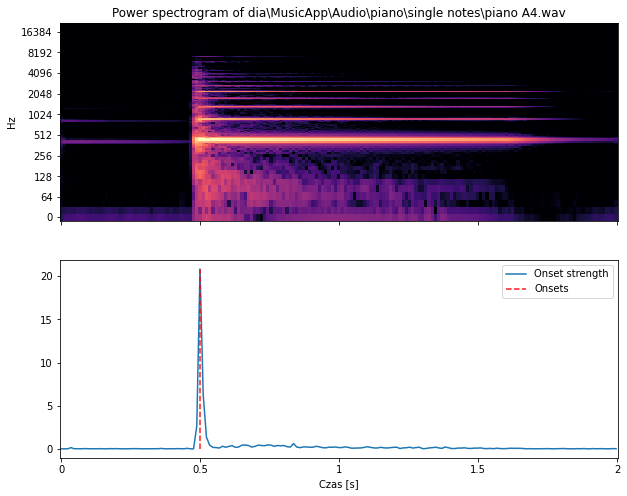

In [6]:
o_env = librosa.onset.onset_strength(y=y, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max)[:400000],
                         x_axis='time', y_axis='log', ax=ax[0], sr=SAMPLE_RATE)
ax[0].set(title=f'Power spectrogram of {audio_name}')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
             linestyle='--', label='Onsets')
ax[1].legend()
ax[1].set_xlabel("Czas [s]")

In [13]:
def compute_cepstrum(signal, sample_freq):
    """Computes cepstrum."""
    frame_size = signal.size

    # filtering with hanning window
    windowed_signal = np.hamming(frame_size) * signal
    dt = 1 / sample_freq  # okres trwania jednej próbki
    freq_vector = np.fft.rfftfreq(frame_size, d=dt)  # wektor wartości częstotliwościowych
    X = np.fft.rfft(windowed_signal)  # dyskretna transformata fouriera dla wartości rzeczywistych
    log_X = np.log(np.abs(X))  # skalowanie do wartości logarytmicznych

    df = freq_vector[1] - freq_vector[0]  # różnica między częstotliwościami w wektorze freq_vector
    quefrency_vector = np.fft.rfftfreq(log_X.size, df)  # wektor wartości częstotliwościowych
    cepstrum = np.fft.rfft(log_X)  # obliczenie jeszcze raz transformaty Fouriera co daje cepstrum

    print(f"dt: {dt}")
    print(f"frame_size: {frame_size}")
    print(f"len(freq_vector) = {len(freq_vector)}   ((frame_size/2) +1)\n")
    print(f"df: {df}")
    print(f"log_X.size: {log_X.size}")
    print(f"quefrency_vector = {len(quefrency_vector)}   ((log_X.size/2) +1)\n")

    return quefrency_vector, cepstrum


def cepstrum_f0_detection(signal, sample_freq, fmin=100, fmax=640):
    """Returns f0 based on cepstral processing."""
    quefrency_vector, cepstrum = compute_cepstrum(signal, sample_freq)
    # extract peak in cepstrum in valid region
    valid = (quefrency_vector > 1 / fmax) & (quefrency_vector <= 1 / fmin)  # extracting valid region of cepstrum
    max_quefrency_index = np.argmax(np.abs(cepstrum)[valid])  # quefrency index with max value
    f0 = 1 / quefrency_vector[valid][max_quefrency_index]
    print(cepstrum.shape)
    return f0


window_size = 2048

# audio_path = audio_files[7]
# y, sr = librosa.load(audio_path, sr=44100)
audio_name = audio_path[6:]
fmin, fmax = 80, 640

freq = cepstrum_f0_detection(y, sr, fmin=fmin, fmax=fmax)
print(f"Dźwięk uzyskany ze ścieżki {audio_name}:    {round(freq, 2)} [Hz]")

dt: 2.2675736961451248e-05
frame_size: 88200
len(freq_vector) = 44101   ((frame_size/2) +1)

df: 0.5
log_X.size: 44101
quefrency_vector = 22051   ((log_X.size/2) +1)

(22051,)
Dźwięk uzyskany ze ścieżki dia\MusicApp\Audio\piano\single notes\piano A4.wav:    450.01 [Hz]


Text(0.5, 1.0, 'Fourier spectrum')

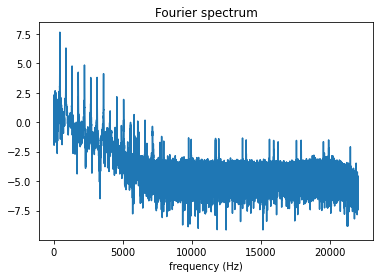

In [8]:
frame_size = y.size
# sound_freq = 261.626
# sound_freq = 523.251

sound_freq = 146.832

windowed_signal = np.hamming(frame_size) * y
dt = 1 / sr
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
X = np.fft.rfft(windowed_signal)
log_X = np.log(np.abs(X))

fig, ax = plt.subplots()
ax.plot(freq_vector, log_X)
ax.set_xlabel('frequency (Hz)')
ax.set_title('Fourier spectrum')

In [9]:
cepstrum = np.fft.rfft(log_X)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(log_X.size, df)
print(log_X.size)
print(quefrency_vector)
print(len(quefrency_vector))

44101
[0.00000000e+00 4.53504456e-05 9.07008911e-05 ... 9.99886624e-01
 9.99931974e-01 9.99977325e-01]
22051


[False False False ... False False False]


Text(0.5, 1.0, 'cepstrum')

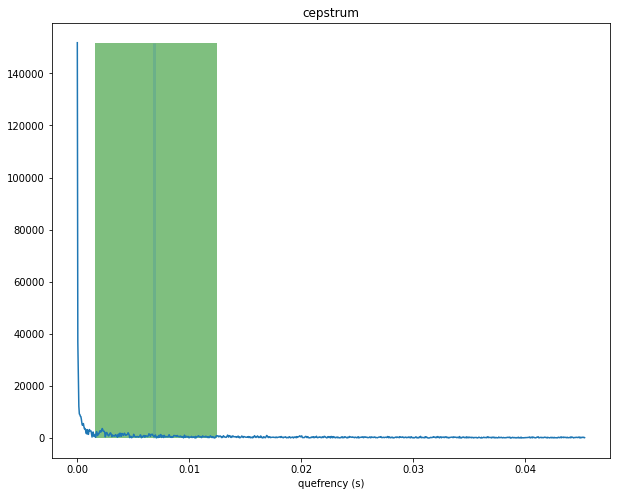

In [10]:
import matplotlib.collections as collections

fig, ax = plt.subplots(figsize=(10, 8))
ax.vlines(1 / sound_freq, 0, np.max(np.abs(cepstrum)), alpha=.2, lw=3, label='expected peak')
ax.plot(quefrency_vector[0:1000], np.abs(cepstrum)[:1000])
valid = (quefrency_vector > 1 / fmax) & (quefrency_vector <= 1 / fmin)
print(valid)
collection = collections.BrokenBarHCollection.span_where(
    quefrency_vector, ymin=0, ymax=np.abs(cepstrum).max(), where=valid, facecolor='green', alpha=0.5,
    label='valid pitches')
ax.add_collection(collection)
ax.set_xlabel('quefrency (s)')
ax.set_title('cepstrum')
    # ax[1, 0].plot(freq_vector[:8000], log_X[:8000], label="ln|X(f)|")
    # ax[1, 0].text(-0.1, 0.5, s='c)', transform=ax[1, 0].transAxes, va='top', ha='right')
    # ax[1, 0].legend(loc='upper right')
    # ax[1, 0].set_xlabel("Częstotliwość [Hz]")
    # ax[1, 0].set_title('Widmo sygnału')
    # ax[1, 0].grid()ax.legend()